In [1]:
import cv2
import numpy as np
np.set_printoptions(threshold=np.inf)
from matplotlib import pyplot as plt
from os.path import isfile, join
from os import listdir
from sklearn import preprocessing
from skimage import filters

# TASK 1 - Compute image descriptors (QS1)

### Calcular els histogrames de totes les imatges de la carpeta especificada a "imagesFolder"
Aquí la idea es fer el bucle que recorre totes les imatges i calcula el histograma de cadascuna d'elles, afegint el resultat a una matriu d'histogrames que després ens servirán per calcular les "Similarity measures".
Cada fila correspondrà a una imatge. 

In [ ]:
imagesFolder = "./bbdd/"
histogram_bbdd_matrix = np.empty([0, 256*3]) #Creem una matriu buida
print(histogram_bbdd_matrix.shape)
for filename in sorted(listdir(imagesFolder)):
    if(filename != '.DS_Store'):
        print("******************************************************************************")
        print("IMAGE: " + filename)
        print("******************************************************************************")

        img = cv2.imread(imagesFolder + filename)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2Lab)
        
        colorx = ('x','y','z')
        hist_img = np.empty([0,0])
        for i,col in enumerate(colorx):
            hist = cv2.calcHist([img],[i],None,[256],[0,256]) #Calculem histogrames
            hist = preprocessing.normalize(hist, norm='max') #Normalitzem histogrames
            hist_t = hist.transpose()
            print(hist_t.shape)
            if i == 0:
                hist_img = hist_t
            else:
                hist_img = np.concatenate((hist_img, hist_t), axis = 1)
            
        histogram_bbdd_matrix = np.vstack((histogram_bbdd_matrix, hist_img))   

In [ ]:
print(histogram_bbdd_matrix.shape)

### Calcular els histogrames de totes les imatges de la carpeta de query (qsd1_w1)

In [ ]:
queryFolder = "./qsd1_w1/"
histogram_query_matrix = np.empty([0, 256*3])
for filename in sorted(listdir(queryFolder)):
    if(filename != '.DS_Store' and (filename.split('.')[1] == 'jpg' or filename.split('.')[1] == 'png')):
        print("******************************************************************************")
        print("./qsd1_w1/" + filename)
        print("******************************************************************************")

        query_img = cv2.imread(queryFolder + filename)
        query_img = cv2.cvtColor(query_img,cv2.COLOR_BGR2Lab)
        color = ('b','g','r')
        hist_query = np.empty([0, 256*3])
        
        for i,col in enumerate(color):
            histr = cv2.calcHist([query_img],[i],None,[256],[0,256])
            histr = preprocessing.normalize(histr, norm='max')
            histr = histr.transpose()
            if i == 0:
                hist_query = histr
            else:
                hist_query = np.concatenate((hist_query,histr), axis = 1)
        
        histogram_query_matrix = np.vstack((histogram_query_matrix, hist_query))
    


In [ ]:
print(histogram_query_matrix.shape)

# TASK 2 - Similarity measures

### Euclidean distance

In [ ]:
from scipy.spatial import distance

dst = np.zeros((30, 279))
matrix_retrieval = np.zeros((30,10))

for query_image_index in range(0,len(histogram_query_matrix)): 
    for bbdd_image_index in range(0, len(histogram_bbdd_matrix)):
        
        #Euclidian distance 1
        dst[query_image_index,bbdd_image_index] = distance.euclidean(histogram_query_matrix[query_image_index,:], histogram_bbdd_matrix[bbdd_image_index,:])
        
        #Euclidian distance 2
        dst[query_image_index,bbdd_image_index] = np.linalg.norm(histogram_query_matrix[query_image_index,:] - histogram_bbdd_matrix[bbdd_image_index,:], ord=1)
        
        #Bray Curtis Distance
        dst[query_image_index,bbdd_image_index] = distance.braycurtis(histogram_query_matrix[query_image_index,:], histogram_bbdd_matrix[bbdd_image_index,:])
    
    matrix_retrieval[query_image_index,:] = np.argsort(dst[query_image_index,:])[:10]

print(matrix_retrieval)

# Task 4

In [ ]:
import ml_metrics as metrics
import pickle

with open('./qsd1_w1/gt_corresps.pkl', 'rb') as fd:
        ll = pickle.load(fd)
        print(ll)

#Convertir idx(numpy) a list of lists
matrix_retrieval_lst = matrix_retrieval.tolist()

#print(matrix_retrieval_lst)

ll_prp = np.zeros((len(ll),1))

for i in range(0,len(ll)):
    ll_prp[i] = ll[i][0][1]

ll_prp_lst = ll_prp.tolist()

mapak = metrics.average_precision.mapk(ll_prp_lst, matrix_retrieval_lst, k=10)        

print(mapak)

# Task 5

In [330]:
query2folder = './qsd2_w1/'

histogram_query2_matrix = np.empty([0, 256*3])
for filename in sorted(listdir(query2folder)):
    count = 0
    if(filename != '.DS_Store' and (filename.split('.')[1] == 'jpg')):
        print("******************************************************************************")
        print("./qsd1_w1/" + filename)
        print("******************************************************************************")

        query_img = cv2.imread(query2folder + filename)
        
        gray = cv2.cvtColor(query_img2, cv2.COLOR_BGR2GRAY)

        ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

        # noise removal
        kernel = np.ones((3,3),np.uint8)
        opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

        # sure background area
        sure_bg = cv2.dilate(opening,kernel,iterations=3) #Fals. El sure 


        # Finding sure foreground area
        dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,3)
        ret, sure_fg = cv2.threshold(dist_transform,0.6*dist_transform.max(),255,0)



        # Finding unknown region
        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg,sure_fg)

        # Marker labelling
        ret, markers = cv2.connectedComponents(sure_fg)

        markers[markers != 0] = 200

        markers[0:35,:] = 100
        sure_fg[0:35,:] = 100
        markers[len(markers)-36:len(markers)-1,:] = 100
        sure_fg[len(markers)-36:len(markers)-1,:] = 100
        markers[:,0:35] = 100
        sure_fg[:,0:35] = 100
        markers[:,len(markers[0,:])-36:len(markers[0,:])-1] = 100
        sure_fg[:,len(markers[0,:])-36:len(markers[0,:])-1] = 100

        # Add one to all labels so that sure background is not 0, but 1
        markers = markers+1

        # Now, mark the region of unknown with zero
        markers[sure_fg == 0] = 0

        markersres = cv2.watershed(query_img2,markers)

        markersres[markersres == 201] = 255
        markersres[markersres == 101] = 0
        markersres[markersres == -1] = 255
        
        #Make the mask binary
        markersres = markersres/np.max(markersres)
        
        #Count the number of black pixels (markersres = 0) --> No sembla que funcioni això encara. No em crec que totes les imatges tinguin el mateix número de 0s i 1s.
        unique, counts = np.unique(markersres, return_counts=True)
        print(counts)
        
        #Compute the histogram
        query_img = query_img * markersres #Aquesta part d'aqui no funciona tampoc diria de moment
        
        query_img = cv2.cvtColor(query_img,cv2.COLOR_BGR2Lab)
        color = ('b','g','r')
        hist_query = np.empty([0, 256*3])
        for i,col in enumerate(color):
            histr = cv2.calcHist([query_img],[i],None,[256],[0,256])
            histr = preprocessing.normalize(histr, norm='max')
            histr = histr.transpose()
            if i == 0:
                hist_query = histr
            else:
                hist_query = np.concatenate((hist_query,histr), axis = 1)
        
        #Discount the number of black pixels from the corresponding bin on the histogram. 
        #Quin és el bin del negre a l'histograma? Imagino que si plotem hi haurà un pic o si fem servir np.max ho tindrem.
        
        #Save to the histogram_query matrix      
        #histogram_query_matrix = np.vstack((histogram_query_matrix, hist_query))
        
        


******************************************************************************
./qsd1_w1/00000.jpg
******************************************************************************
[233453   2167]


ValueError: operands could not be broadcast together with shapes (2200,1772,3) (495,476) 

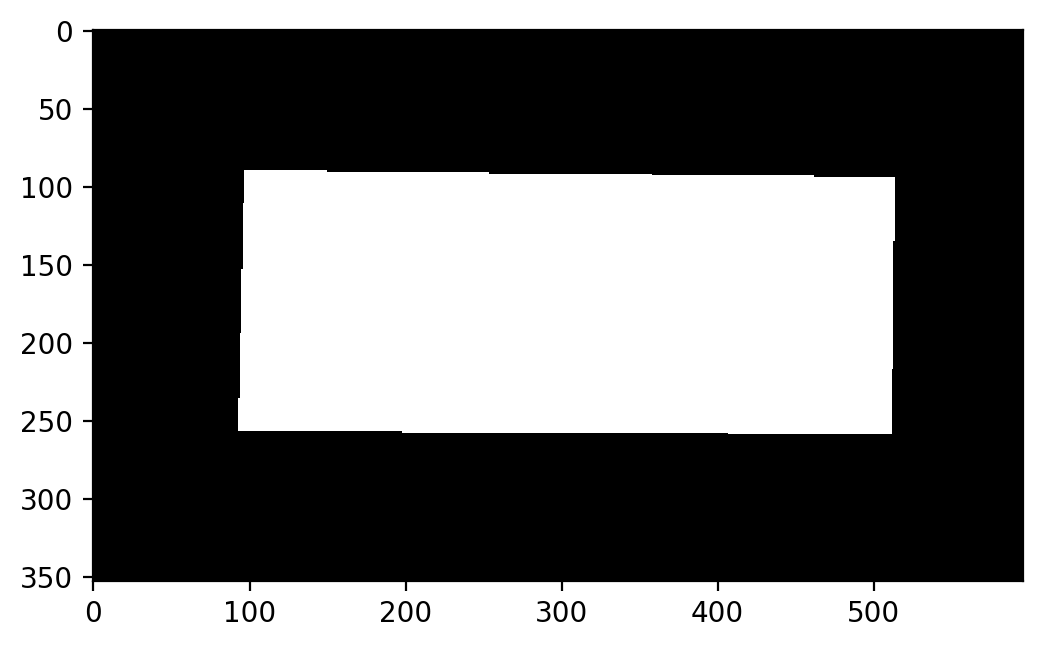

In [306]:
mask = cv2.imread('./qsd2_w1/00029.png')
plt.imshow(mask)

In [ ]:
print(len(query_img2))

[ -1   0 255]


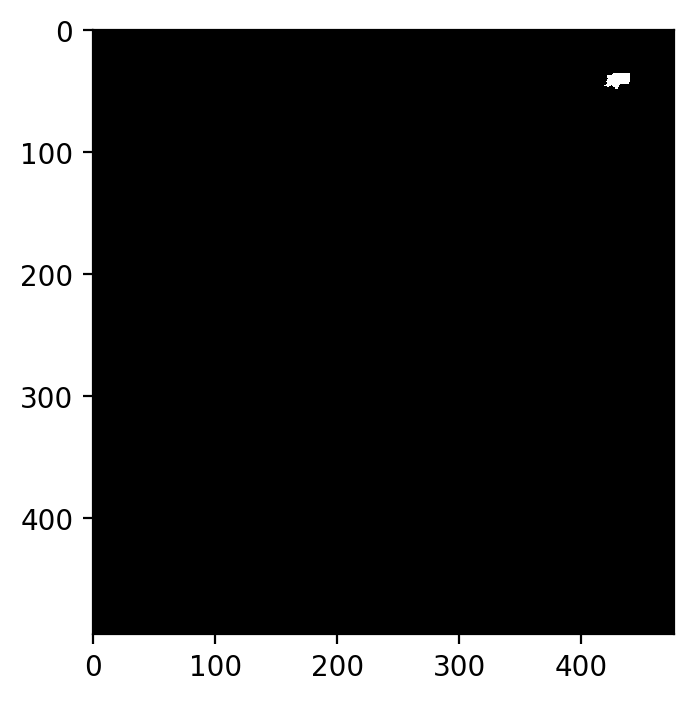

In [312]:
query_img2 = cv2.imread('./qsd2_w1/00025.jpg')
gray = cv2.cvtColor(query_img2, cv2.COLOR_BGR2GRAY)

ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3) #Fals. El sure 


# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,3)
ret, sure_fg = cv2.threshold(dist_transform,0.6*dist_transform.max(),255,0)



# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

markers[sure_fg != 0] = 200

markers[0:35,:] = 100
sure_fg[0:35,:] = 100
markers[len(markers)-36:len(markers)-1,:] = 100
sure_fg[len(markers)-36:len(markers)-1,:] = 100
markers[:,0:35] = 100
sure_fg[:,0:35] = 100
markers[:,len(markers[0,:])-36:len(markers[0,:])-1] = 100
sure_fg[:,len(markers[0,:])-36:len(markers[0,:])-1] = 100

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[sure_fg == 0] = 0

markersres = cv2.watershed(query_img2,markers)

markersres[markersres == 201] = 255
markersres[markersres == 101] = 0

print(np.unique(markersres))

plt.imshow(markersres)




